# Inferring Attractant Dynamics Parameters

This notebook will run ensemble mcmc to infer parameters in production-diffusion model from previously inferred observed bias (from tracking data) at different points in space and time. The model goes something like this:

The diffusion equation gives us a solution to calculate the concentration of attractant at any point $r$ and $t$ in space. It takes parameters $q$, $D$ and $\tau$, which represent the production rate, the diffusion coefficient and the diffusion time respectively. This is then used, along with the theory of receptor-lingand binding kinetics, to predict the number of bound complexes that should appear on either side of a migrating leukocyte. This equation takes parameters $R_0$ and $\kappa_d$. Finally, the observed bias of a cell at time $t$ a distance $r$ from the wound is assumed to be linearly related to the difference between the concentration of bound receptors at the front and rear of the cell. 

This means, given a set of parameters $\theta = \{q, \, D, \, \tau, \, R_0, \, \kappa_d, \, m, \, b_0\}$, we can calculate the observed bias one would expect to occur at any point in space and time. 

NOTE: this notebook repeats some of the definitions that could be imported from inference/attractant_inference.py, because the multiprocessing wasn't working with the imports for a yet to be determined reason. This is a work-around, and one could a) try to fix multiprocessing with the imports as intended, b) try a different implementation of ensemble mcmc, such as in jax/numpyro https://num.pyro.ai/en/latest/mcmc.html#numpyro.infer.ensemble.AIES (see also https://github.com/dfm/emcee/issues/499) c) do away without ensemble sampling, as it turned out to not be of much benefit (and use eg pymc for sampling instead).


In [1]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import emcee
from in_silico.sources import Wound,PointWound
from Utilities.distributions import Uniform, TruncatedNormal


In [2]:
filesuffix = "_excluding_e2e_lt30"

ob_readings_control = {}
ob_readings_mcr = {}

distance = [54, 105, 195, 305, 430] # Liepe bins: [54, 105, 195, 305, 430]; 2x bins: [54, 87.5, 122.5, 167.5, 222.5, 277.5, 332.5, 395]
time = [2.5,7.5,12.5,17.5,22.5]
time_labels = ["0-5","5-10","10-15","15-20","20-25"]
stepSizeTimeBins = 1
if stepSizeTimeBins==2: # because np.round will round 4.5 to 4 (to the nearest even number...)
    nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))+1
elif stepSizeTimeBins==1:
    nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))

burnin_BP= 3000
thin_BP= 40

# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats
def bias_param_samples_from_file(emcee_samples):
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    flattened_chain = emcee_samples.get_chain(discard=burnin_BP, thin=thin_BP, flat=True)
    w = flattened_chain[:, 0]  # The weighting parameter from the walker posterior array
    # p = flattened_chain[:, 1]  # The weighting parameter from the walker posterior array
    b = flattened_chain[:, 2]  # The bias parameter from the walker posterior array
    observedBias = w * b  # The observed bias parameter from the walker posterior array
    # observedPersistence = (1 - w) * p  # The observed persistence parameter from the walker posterior array
    mean_ob = np.mean(observedBias)
    std_ob = np.std(observedBias)
    # mean_op = np.mean(observedPersistence)
    # std_op = np.std(observedPersistence)
    return mean_ob, std_ob#, mean_op, std_op

def bias_values_control(i, j): 
    control_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_CTR_revision'+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(control_data)

def bias_values_mcr(i, j): 
    mcr_data = emcee.backends.HDFBackend('../data/BP_inference/Single_wound_MCR_revision'+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(mcr_data)

"""
Here we define a nested for loop which populates the dictionary ob_readings with the mean and std of the current 
observed bias. This is then ready to be read into our attractant inference as the data for the inference pipeline. 
"""
for i in range(nTimeBins):
    for j in range(len(distance)):
        ObBias_cont = bias_values_control(j, i*stepSizeTimeBins)
        ObBias_mcr = bias_values_mcr(j, i*stepSizeTimeBins)

        ob_mean_cont = ObBias_cont[0]
        ob_std_cont = ObBias_cont[1]
        
        ob_mean_mcr = ObBias_mcr[0]
        ob_std_mcr = ObBias_mcr[1]
        ob_readings_control[(distance[j], time[i*stepSizeTimeBins])] = (ob_mean_cont, ob_std_cont)
        ob_readings_mcr[(distance[j], time[i*stepSizeTimeBins])] = (ob_mean_mcr, ob_std_mcr)

In [3]:
n_walkers = 40
priors = [Uniform(0,3500), # q # Reference: Liepe, Taylor, et al. 2012 have a 1D diffusion model with amplitude parameter U[0,1000] over 1.5hrs or more, per unit length, so we estimate 1000/90mins * wound circumference (here max 100 microns diameter) to be the upper bound for q
        TruncatedNormal(200, 50), #Uniform(64,1000), #TruncatedNormal(200, 50), # D # Reference: Weavers, Liepe, et al. 2016 Fig. 3C
        TruncatedNormal(18, 3), #Uniform(0,25), # τ # Reference: Weavers, Liepe, et al. 2016 Fig. 3D
        Uniform(0, 10000), # R0 # Reference: Liepe, Taylor, et al. 2012 Table 1
        Uniform(0, 10000), # κ # Reference: Liepe, Taylor, et al. 2012 Table 1
        Uniform(0, 100), # m 
        TruncatedNormal(0.02, 0.02)] # b0 # Reference: Weavers, Liepe, et al. 2016 Fig. 3E

# Sets the wound location
wound = PointWound(position=np.array([0, 0]))

# This is the initial position of the walkers
initial = np.array([prior.mean() for prior in priors])
ndim = len(initial)
p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(n_walkers)]

In [6]:
# this code could be imported instead, by importing the AttractantInferer class and creating an instance from which to run the ensemble_infer, but with that the parallalisation was not as quick
from inference.attractant_inference import AttractantInferer

attractantInfererCtr = AttractantInferer(ob_readings_control,priors=priors, wound=wound, t_units='minutes')

# This implements the emcee library for Ensemble Monte Carlo method
def log_probabilityCtr(params: np.ndarray):
    lp = attractantInfererCtr.log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + attractantInfererCtr.log_likelihood(params)

In [7]:
import multiprocessing as mp
mp.set_start_method('fork', force=True)

# # if wanting to run for a fixed number of samples, without checking for convergence, one can use this code, otherwise see next cell
# n_iter = 10000
# with mp.Pool() as pool:
#     sampler = emcee.EnsembleSampler(n_walkers, ndim, log_probabilityCtr, pool=pool)
#     sampler.run_mcmc(p0, n_iter, progress=True)

100%|██████████| 10000/10000 [00:58<00:00, 171.27it/s]


In [15]:
# running the sampling while checking for convergence, as in https://emcee.readthedocs.io/en/stable/tutorials/monitor/
max_n = 1000000
listparamindcs = [1,2,6] # only check autocorrelation for parameters we expect to be able to infer well

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n) # could probably be reduced to max_n/ checkevery?

# This will be useful to testing convergence
old_tau = np.inf

# Set up the backend
# Don't forget to clear it in case the file already exists (and you want to start a new sampler)
filename = 'attractant_inference_CTR_revision'+filesuffix+'.h5'
backend = emcee.backends.HDFBackend(filename)
# uncomment this next line if initializing a new sampler
backend.reset(n_walkers, ndim)
print("Initial size: {0}".format(backend.iteration))
if backend.iteration==0:
    starting_from = p0
elif backend.iteration>0:
    starting_from = backend.get_last_sample()

with mp.Pool() as pool:
    # Initialize the sampler
    sampler = emcee.EnsembleSampler(n_walkers, ndim, log_probabilityCtr, pool=pool, backend=backend)
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(starting_from, iterations=max_n, progress=True):
        # Only check convergence every 10000 steps
        if sampler.iteration % 10000:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau[listparamindcs]) 
        index += 1

        # Check convergence
        converged = np.all(tau[listparamindcs] * 50 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

print("Final size: {0}".format(backend.iteration))

Initial size: 0


 74%|███████▍  | 740000/1000000 [2:02:55<43:11, 100.33it/s]   

Final size: 740000


Text(0, 0.5, 'mean $\\hat{\\tau}$')

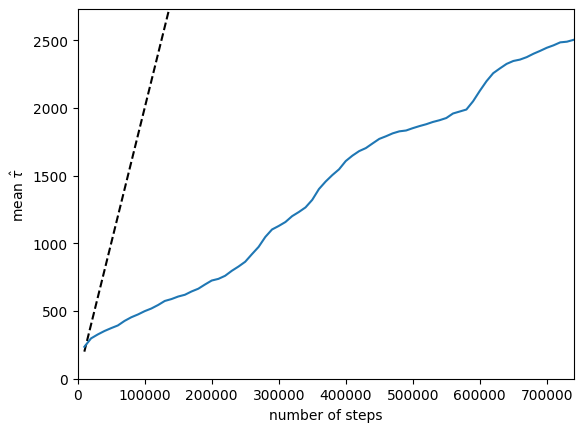

In [16]:
import matplotlib.pyplot as plt
# note this plot won't make sense if you've continued sampling from a saved file, but haven't saved the intermediate autocorr values as well
n = 10000 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 50.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")

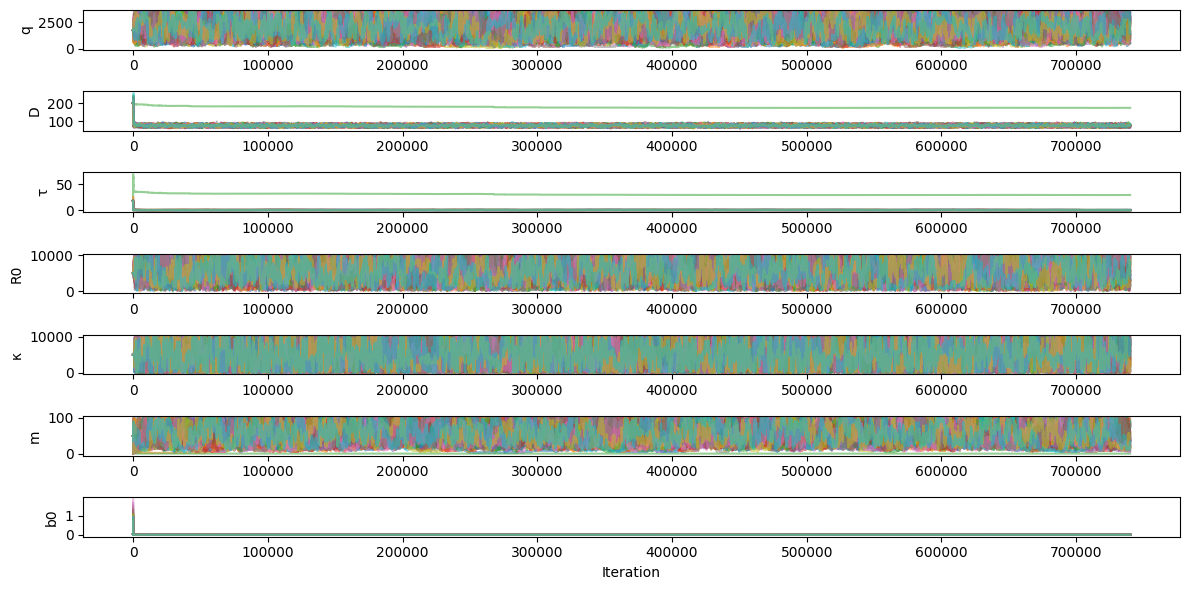

In [17]:
# Trace Plots
labels = ['q','D','τ','R0','κ','m','b0']
ndim = len(labels)

samples = sampler.get_chain()
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    for walker in range(n_walkers):
        plt.plot(samples[:, walker, dim], alpha=0.5)
    plt.ylabel(labels[dim])
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

In [20]:
tau = sampler.get_autocorr_time(tol=0) # only need to run this again if you have loaded the sampler from file
burnin = int(2 * np.max(tau))
thin = int(np.min(tau))

samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))

burn-in: 16463
thin: 119
flat chain shape: (243200, 7)


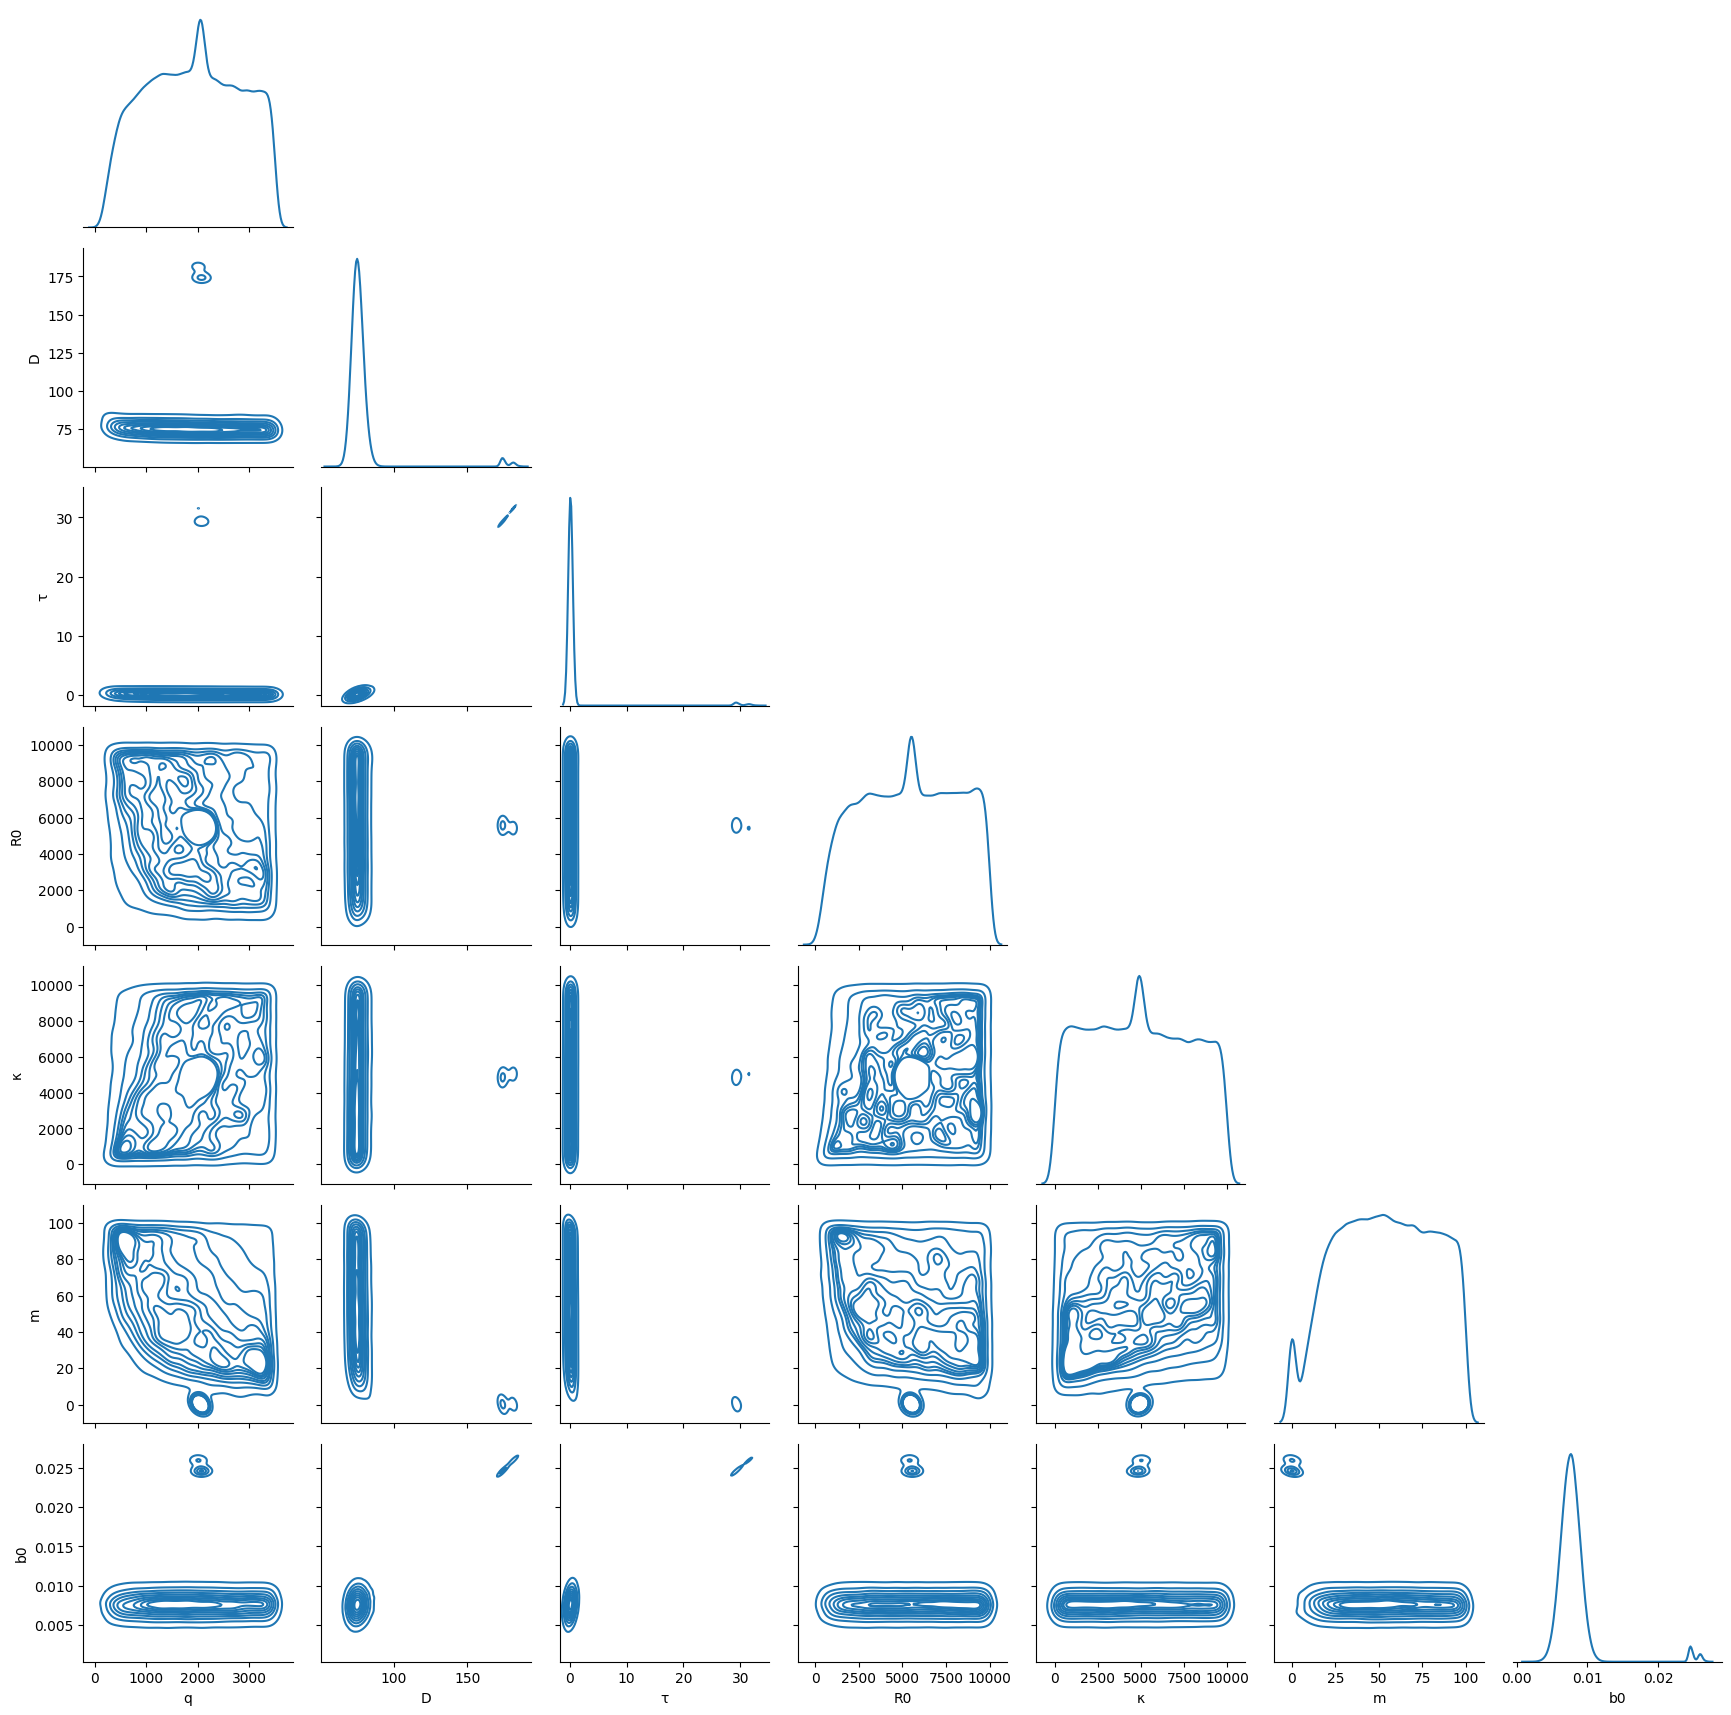

In [21]:
# Pairwise marginal/joint posterior Plots
labels = [labels[dim] for dim in range(ndim)]
samples_df = pd.DataFrame(data=samples, columns=labels)

g = sns.PairGrid(samples_df, diag_sharey=False, corner=True)
# g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)


now repeat the sampling for the mcr data

In [22]:
priors_mcr = [Uniform(0,3500), # q # Reference: Liepe, Taylor, et al. 2012 have a 1D diffusion model with amplitude parameter U[0,1000] over 1.5hrs or more, per unit length, so we estimate 1000/90mins * wound circumference (here max 100 microns diameter) to be the upper bound for q
        Uniform(0,1000), # D
        Uniform(0,25), # τ
        Uniform(0, 10000), # R0 # Reference: Liepe, Taylor, et al. 2012 Table 1
        Uniform(0, 10000), # κ # Reference: Liepe, Taylor, et al. 2012 Table 1
        Uniform(0, 100), # m 
        TruncatedNormal(0.02, 0.02)] # b0 # Reference: Weavers, Liepe, et al. 2016 Fig. 3E

initial = np.array([prior.mean() for prior in priors])
ndim = len(initial)
p0 = [np.array(initial) + 1e-3 * np.random.randn(ndim) for i in range(n_walkers)]

In [23]:
# this code could be imported instead, by importing the AttractantInferer class and creating an instance from which to run the ensemble_infer, but with that the parallalisation was not as quick
from inference.attractant_inference import AttractantInferer

attractantInfererMcr = AttractantInferer(ob_readings_mcr,priors=priors, wound=wound, t_units='minutes')

# This implements the emcee library for Ensemble Monte Carlo method
def log_probabilityMcr(params: np.ndarray):
    lp = attractantInfererMcr.log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + attractantInfererMcr.log_likelihood(params)

In [24]:
# running the sampling while checking for convergence, as in https://emcee.readthedocs.io/en/stable/tutorials/monitor/

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Set up the backend
# Don't forget to clear it in case the file already exists (and you want to start a new sampler)
filename = 'attractant_inference_MCR_revision'+filesuffix+'.h5'
backend = emcee.backends.HDFBackend(filename)
# uncomment this next line if initializing a new sampler
backend.reset(n_walkers, ndim)

print("Initial size: {0}".format(backend.iteration))
if backend.iteration==0:
    starting_from = p0
elif backend.iteration>0:
    starting_from = backend.get_last_sample()

with mp.Pool() as pool:
    # Initialize the sampler
    sampler = emcee.EnsembleSampler(n_walkers, ndim, log_probabilityMcr, pool=pool, backend=backend)
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(starting_from, iterations=max_n, progress=True):
        # Only check convergence every 10000 steps
        if sampler.iteration % 10000:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau[listparamindcs]) 
        index += 1

        # Check convergence
        converged = np.all(tau[listparamindcs] * 50 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

print("Final size: {0}".format(backend.iteration))

Initial size: 0


100%|██████████| 1000000/1000000 [2:42:11<00:00, 102.76it/s]  

Final size: 1000000


Text(0, 0.5, 'mean $\\hat{\\tau}$')

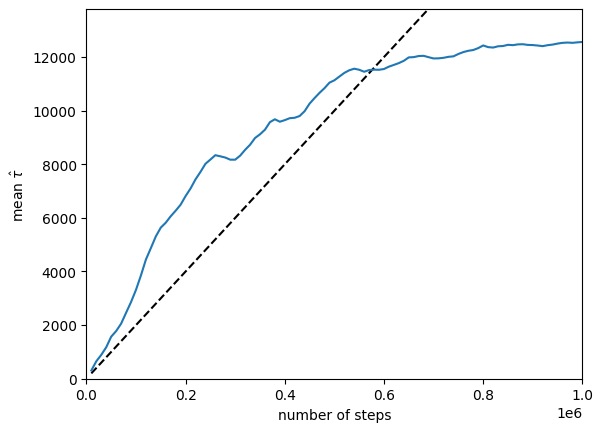

In [25]:
# note this plot won't make sense if you've continued sampling from a saved file, but haven't saved the intermediate autocorr values as well
n = 10000 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 50.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")

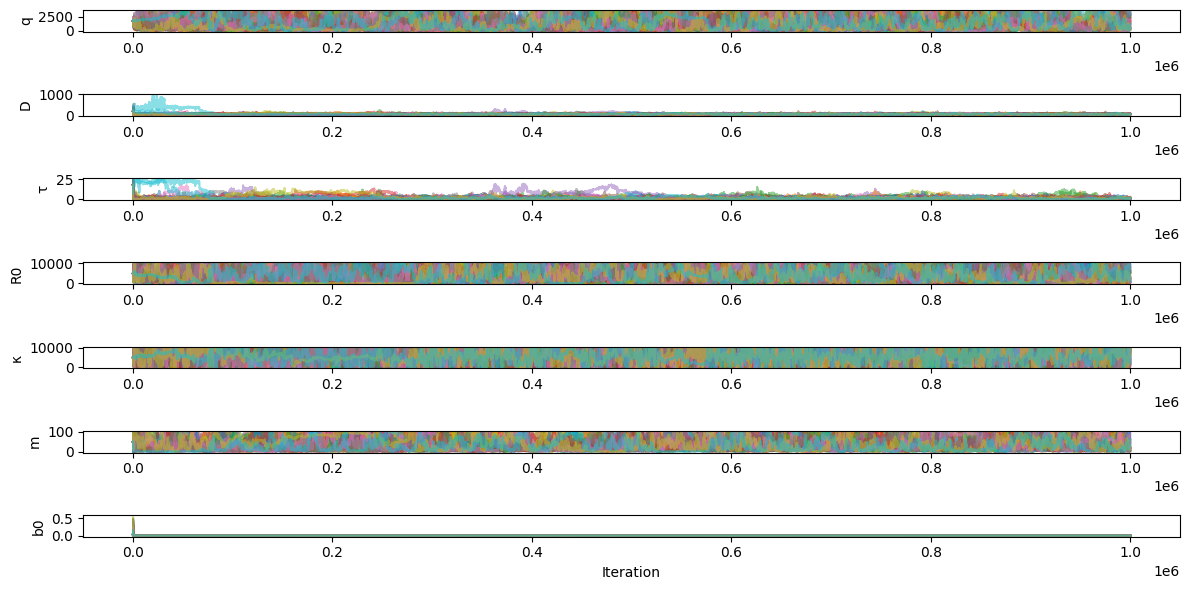

In [26]:
# Trace Plots
labels = ['q','D','τ','R0','κ','m','b0']
ndim = len(labels)

samples = sampler.get_chain()
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    for walker in range(n_walkers):
        plt.plot(samples[:, walker, dim], alpha=0.5)
    plt.ylabel(labels[dim])
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

In [27]:
tau = sampler.get_autocorr_time(tol=0) # only need to run this again if you have loaded the sampler from file
burnin = int(2 * np.max(tau))
thin = int(np.min(tau))

samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))

burn-in: 41399
thin: 626
flat chain shape: (61240, 7)


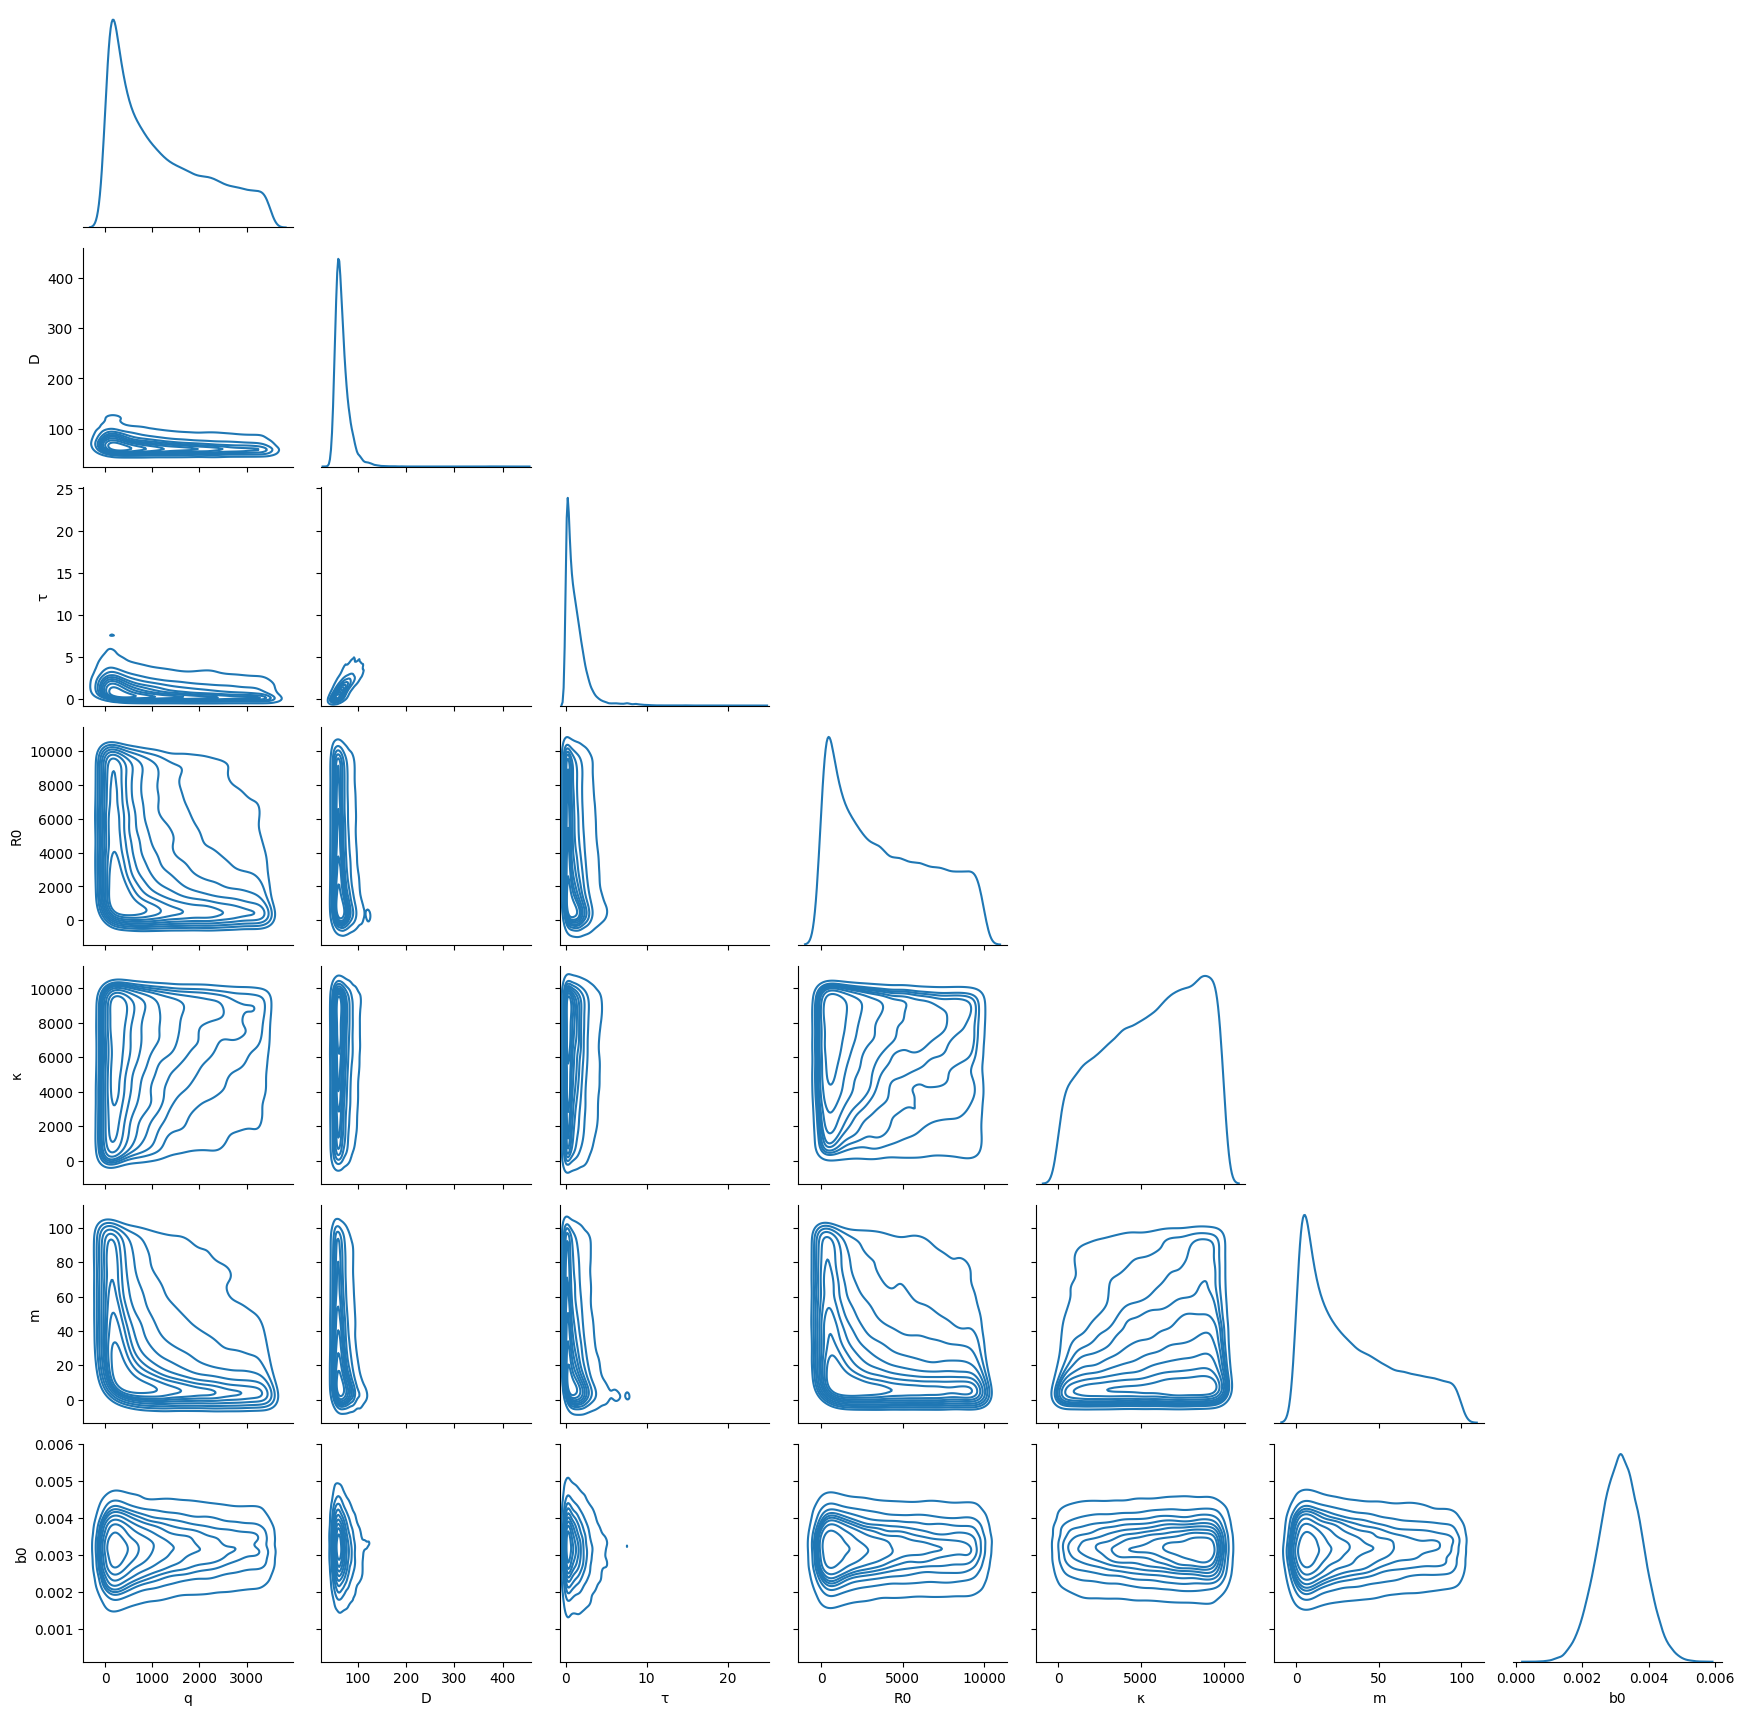

In [28]:
# Pairwise Scatter Plots
labels = [labels[dim] for dim in range(ndim)]
samples_df = pd.DataFrame(data=samples, columns=labels)

g = sns.PairGrid(samples_df, diag_sharey=False, corner=True)
# g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)